In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore')

2025-10-04 12:42:32.394367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759581752.577473      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759581752.628304      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
GCS_PATH = "/kaggle/input/chest-xray-pneumonia/chest_xray"
BATCH_SIZE = 64
IMG_SIZE = (180, 180)
EPOCHS = 15

In [4]:
filenames = tf.io.gfile.glob(GCS_PATH + '/chest_xray/train/*/*')
filenames.extend(tf.io.gfile.glob(GCS_PATH + 'chest_xray/val/*/*'))

filenames = [f for f in filenames if f.split('.')[-1] == 'jpeg']

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)
print(f'total number of files: {len(filenames)}')

total number of files: 5216


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f'normal images count: {COUNT_NORMAL}')

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f'pneumonia images count: {COUNT_PNEUMONIA}')

# large data imbalance, will use data augmentation to try to improve the model (no oversampling)

normal images count: 1079
pneumonia images count: 3093


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1476_virus_2560.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person471_virus_967.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person321_bacteria_1487.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person1050_bacteria_2984.jpeg'
b'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/person65_bacteria_322.jpeg'


I0000 00:00:1759581768.319409      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'train images count: {TRAIN_IMG_COUNT}')

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'val images count: {VAL_IMG_COUNT}')

train images count: 4172
val images count: 1044


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] 
                      for item in tf.io.gfile.glob(GCS_PATH + '/chest_xray/train/*')])
# ignore the DS_Store part, the two classes are pneumonia and normal
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL', '.DS_Store'], dtype='<U9')

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

In [10]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMG_SIZE)

In [11]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print(f'image shape: {image.numpy().shape}')
    print(f'label: {label.numpy()}')

image shape: (180, 180, 3)
label: True


In [14]:
test_list_ds = tf.data.Dataset.list_files(GCS_PATH + '/chest_xray/test/*/*')
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(f'number of test samples: {TEST_IMAGE_COUNT}')

number of test samples: 624


In [15]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [16]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [17]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i])
        if label_batch[i]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

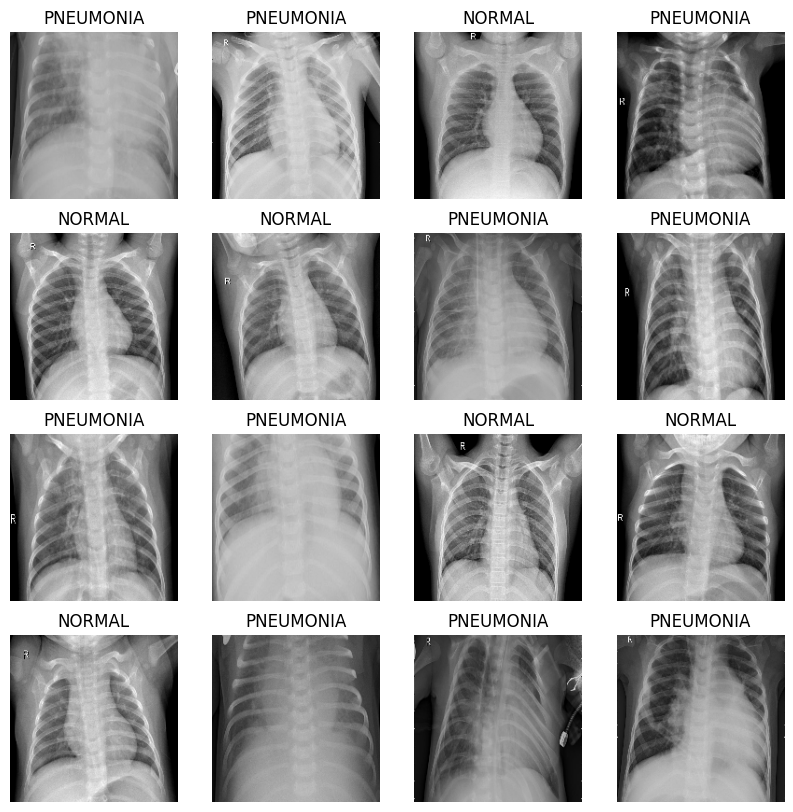

In [18]:
image_batch, label_batch = next(iter(train_ds))

show_batch(image_batch.numpy(), label_batch.numpy())

In [19]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
    tf.keras.layers.Rescaling(1./255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15, fill_mode='reflect'),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomSharpness(0.1)
])

In [21]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [22]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [23]:
input_shape = ((IMG_SIZE[0], IMG_SIZE[1], 3))

model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=input_shape),
            resize_and_rescale,
            data_augmentation,
            
            tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(),
    
            conv_block(32),
            conv_block(64),
            conv_block(128),
            tf.keras.layers.Dropout(0.2),
            conv_block(256),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Flatten(),
    
            dense_block(128, 0.4),
            dense_block(256, 0.5),
    
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

In [25]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, 
                                                   verbose=1, min_lr=0.0000001)

model.fit(train_ds,
                 steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=val_ds,
                  validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
                  verbose=1,
                  callbacks=[lr_schedule]
                 )

Epoch 1/15


E0000 00:00:1759581791.978597      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_8_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1759581801.323743      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 621ms/step - accuracy: 0.7105 - loss: 0.7008 - val_accuracy: 0.7500 - val_loss: 0.9647 - learning_rate: 0.0010
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.8782 - loss: 0.3465 - val_accuracy: 0.7480 - val_loss: 1.7836 - learning_rate: 0.0010
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8975 - loss: 0.2879
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.8973 - loss: 0.2881 - val_accuracy: 0.7490 - val_loss: 1.8247 - learning_rate: 0.0010
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9266 - loss: 0.2163 - val_accuracy: 0.7490 - val_loss: 1.8716 - learning_rate: 2.0000e-04
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9164 - loss: 0.2218
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9163 - loss: 0.2220 - val_ac

In [26]:
model.evaluate(test_ds, steps=TEST_IMAGE_COUNT//BATCH_SIZE)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.8997 - loss: 0.2701


[0.2733202278614044, 0.9027777910232544]

In [27]:
test_ds_list = list(test_ds)

In [28]:
images_test = []
labels_test = []

for s in test_ds_list:
    images_test.extend(s[0])
    labels_test.extend(s[1])
    
X_test, y_test = np.array(images_test), np.array(labels_test)
y_test = y_test.reshape((-1, 1))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


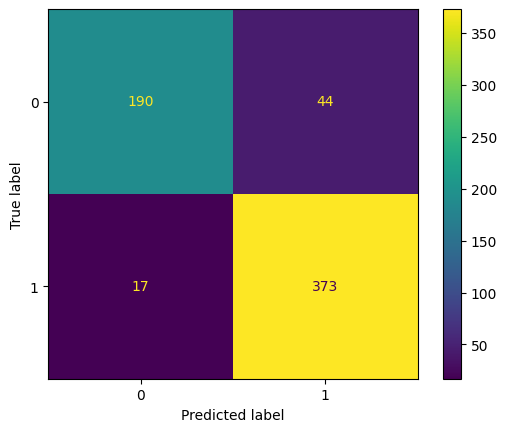

In [29]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(labels_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.81      0.86       234
        True       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



In [31]:
def make_prediction(img_batch):
    pred = model.predict(img_batch)
    return (pred > 0.5).astype(bool)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


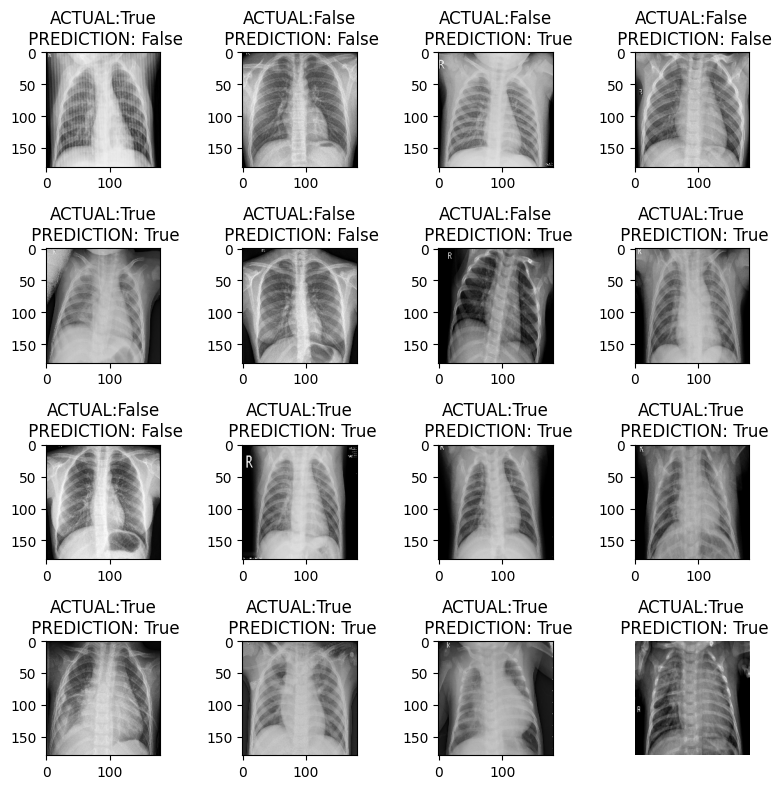

In [32]:
for batch_img, batch_labels in test_ds.take(1):
    images = batch_img[:16]
    labels = batch_labels[:16]
    batch_prediction = make_prediction(images)
    batch_prediction = [f for f in batch_prediction]
    plt.figure(figsize=(8,8))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        plt.title(f'ACTUAL:{labels[i]}\n PREDICTION: {batch_prediction[i][0]}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()